In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import sys, os, re

dir_home = re.sub( 'qml4omics.*', 'qml4omics', os.getcwd() )

sys.path.append( dir_home )

from qml4omics.sage.sage import QuantumSage
import math
import pickle



In [ ]:

# This is the directory where the qml4omics-profiles results are stored on which the sage will be run
dir_results = os.path.join( dir_home, 'results' )

# Path to the compiled results on which the sage will be run
file_input = os.path.join( dir_results, 'Compiled_QMLBench_results.csv' )

# Path for the saved sage object
# For the purposes of this tutorial, we have pre-trained a sage object on a more extensive dataset than in the tutorial github
file_sage = os.path.join( dir_results, 'QMLBench_sage.pkl' )

# Underlying ML type used for sage
sage_type = 'random_forest'

In [4]:
# This loads all the experimental results from the qml4omics-profiler on which the sage will be run
reload = False

if (reload) or (not os.path.exists( file_input )):

    features = ['Feature_Samples_ratio', 'Intrinsic_Dimension', 'Condition number',
        'Fisher Discriminant Ratio', 'Total Correlations', 'Mutual information',
        '# Non-zero entries', '# Low variance features', 'Variation', 'std_var',
        'Coefficient of Variation %', 'std_co_of_v', 'Skewness', 'std_skew',
        'Kurtosis', 'std_kurt', 'Mean Log Kernel Density',
        'Isomap Reconstruction Error', 'Fractal dimension', 'Entropy',
        ]
    features.sort()
    metrics = ['accuracy', 'f1_score', 'time', 'auc']
    metrics.sort()


    # Get results
    path_to_compiled_results = dir_results
    if os.path.isdir(path_to_compiled_results):
        result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path_to_compiled_results) for f in filenames if ('csv' in f) and f != 'RawDataEvaluation.csv']
        results_df = []
        for fl in result:
            if (fl != os.path.join( dir_results, 'Compiled_BatchCCC_results.csv') ) & (fl != os.path.join( dir_results, 'Compiled_QMLBench_results.csv' ) ):
                results_df.append( pd.read_csv(fl) )
        results_df = pd.concat( results_df )
        for f in features:
            results_df[f] = [ round(x,4) for x in results_df[f]]
        results_df['embeddings'] = results_df['embeddings'].fillna('none')
        results_df['model'] = results_df['model'].fillna('none')
        results_df['datatype'] = [ re.sub( '\.csv', '', re.sub( '-.*', '', str(x) ) ) for x in results_df['Dataset'] ]
        results_df[ 'model_embed_datatype'] = [ '_'.join( [str(row.model), str(row.embeddings), str(row.datatype)] ) for idx, row in results_df.iterrows() ]

    else:
        results_df = pd.read_csv( path_to_compiled_results )

    results_df = results_df.reset_index(drop=True)
    results_df[results_df == math.inf] = 0
    results_df = results_df.drop_duplicates()

    results_df.to_csv( os.path.join( file_input ) )

else:
    results_df = pd.read_csv( file_input )


In [5]:
results_df.head()

,Unnamed: 0,Dataset,embeddings,# Features,# Samples,Feature_Samples_ratio,Intrinsic_Dimension,Condition number,Fisher Discriminant Ratio,Total Correlations,...,std_entropy,iteration,model,accuracy,f1_score,time,auc,Model_Parameters,datatype,model_embed_datatype
0,0,iris_binary_class_dataset.csv,pca,3,70,0.0429,2,5.8606,8.3251,0.0,...,0.0,1,dt,1.000000,1.00000,0.004270,1.000000,"{'estimator__ccp_alpha': 0.0, 'estimator__clas...",iris_binary_class_dataset,dt_pca_iris_binary_class_dataset
1,1,iris_binary_class_dataset.csv,pca,3,70,0.0429,2,5.8606,8.3251,0.0,...,0.0,1,lr,1.000000,1.00000,0.007345,1.000000,"{'estimator__C': 1.0, 'estimator__class_weight...",iris_binary_class_dataset,lr_pca_iris_binary_class_dataset
2,2,iris_binary_class_dataset.csv,pca,3,70,0.0429,2,5.8606,8.3251,0.0,...,0.0,1,mlp,1.000000,1.00000,0.125621,1.000000,"{'estimator__activation': 'relu', 'estimator__...",iris_binary_class_dataset,mlp_pca_iris_binary_class_dataset
3,3,iris_binary_class_dataset.csv,pca,3,70,0.0429,2,5.8606,8.3251,0.0,...,0.0,1,nb,1.000000,1.00000,0.004255,1.000000,"{'estimator__priors': None, 'estimator__var_sm...",iris_binary_class_dataset,nb_pca_iris_binary_class_dataset
4,4,iris_binary_class_dataset.csv,pca,3,70,0.0429,2,5.8606,8.3251,0.0,...,0.0,1,pqk,0.966667,0.96663,2.003899,0.966667,"{'feature_map': 'ZZFeatureMap', 'feature_map_r...",iris_binary_class_dataset,pqk_pca_iris_binary_class_dataset


In [7]:
# select a held out dataset on which to test the trained Sage model
held_out_df = results_df[results_df['Dataset'] == 'spirals_data-2.csv' ]
results_df = results_df[results_df['Dataset'] != 'spirals_data-2.csv' ]


In [ ]:
# Load the Quantum Sage with the dataset
reload = False
if (reload) or (not os.path.exists( file_sage )):
    qs = QuantumSage(results_df)
else:
     qs = pickle.load( open(file_sage, 'rb'))


In [ ]:
# Train the sage - for the purposes of this tutorial, we have pre-trained a sage object on a more extensive 
# dataset than in the tutorial github so leave the retrain flag as False
retrain = False

if retrain or (len(qs._results_subsages) == 0):
    qs.train_sub_sages(sage_type=sage_type)
    pickle.dump( qs, open(file_sage,'wb') )

Working on accuracy
Working on dt
Working on lr
Working on mlp
Working on nb
Working on qnn
Working on qsvc
Working on rf
Working on svc
Working on vqc
Working on auc
Working on dt
Working on lr
Working on mlp
Working on nb
Working on qnn
Working on qsvc
Working on rf
Working on svc
Working on vqc
Working on f1_score
Working on dt
Working on lr
Working on mlp
Working on nb
Working on qnn
Working on qsvc
Working on rf
Working on svc
Working on vqc


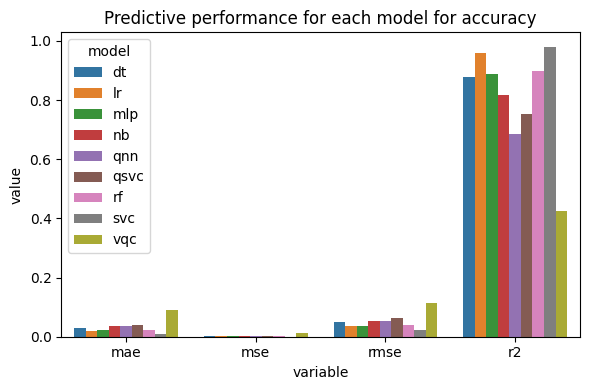

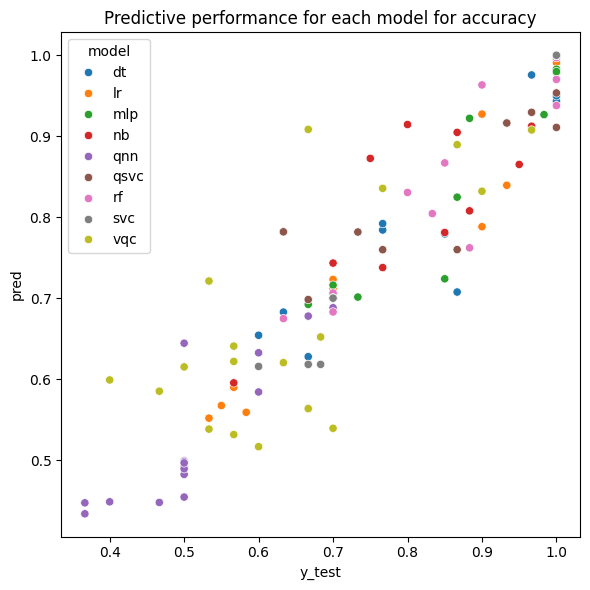

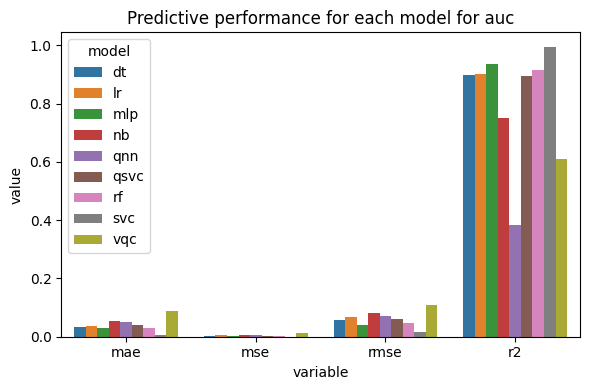

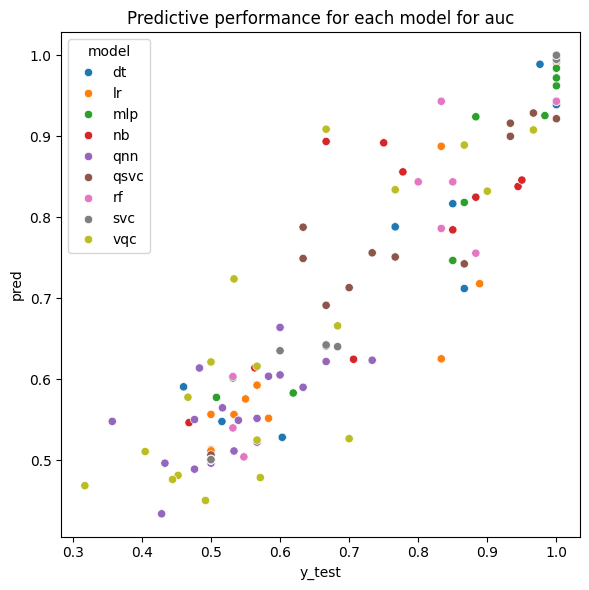

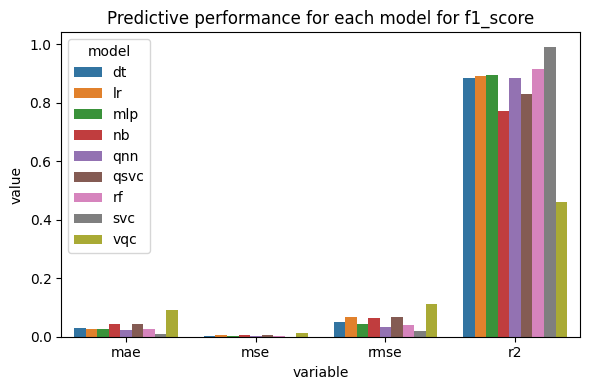

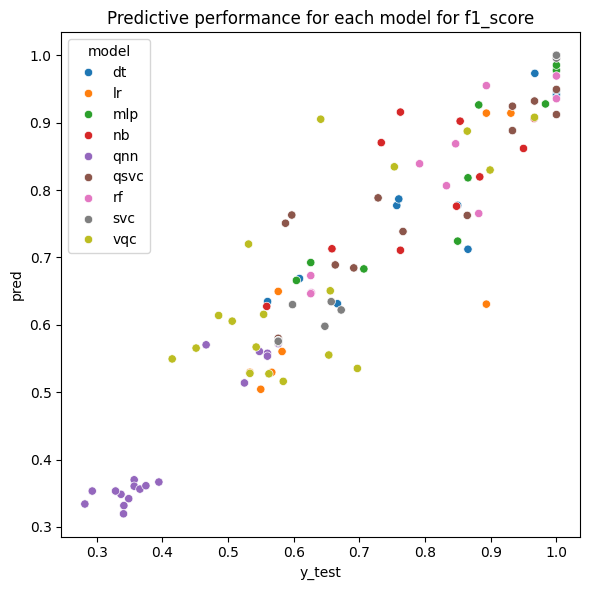

In [ ]:
# Plot results from training - this is the 
qs.plot_results()

### Run Held Out Data

In [ ]:
# Parse out the relevant columns from the held out dataset
_columns_data_features = [ '# Features', '# Samples',
                                'Feature_Samples_ratio', 'Intrinsic_Dimension', 'Condition number',
                                'Fisher Discriminant Ratio', 'Total Correlations', 'Mutual information',
                                '# Non-zero entries', '# Low variance features', 'Variation', 'std_var',
                                'Coefficient of Variation %', 'std_co_of_v', 'Skewness', 'std_skew',
                                'Kurtosis', 'std_kurt', 'Mean Log Kernel Density',
                                'Isomap Reconstruction Error', 'Fractal dimension', 'Entropy',
                                'std_entropy']
_columns_metrics = ['accuracy', 'f1_score', 'auc']
_columns_metadata = ['Dataset', 'embeddings','datatype', 'model_embed_datatype', 'iteration', 'model']

held_out_df_input_data_features_only = held_out_df[_columns_data_features]
held_out_df_input_data_metrics = held_out_df[_columns_metrics]
held_out_df_input_data_metadata = held_out_df[_columns_metadata]

In [9]:
held_out_df.head()

,Unnamed: 0,Dataset,embeddings,# Features,# Samples,Feature_Samples_ratio,Intrinsic_Dimension,Condition number,Fisher Discriminant Ratio,Total Correlations,...,std_entropy,iteration,model,accuracy,f1_score,time,auc,Model_Parameters,datatype,model_embed_datatype
180,180,spirals_data-2.csv,pca,3,70,0.0429,3,1.4553,0.008,0.0,...,0.0,1,dt,0.766667,0.764310,0.003203,0.766667,"{'estimator__ccp_alpha': 0.0, 'estimator__clas...",spirals_data,dt_pca_spirals_data
181,181,spirals_data-2.csv,pca,3,70,0.0429,3,1.4553,0.008,0.0,...,0.0,1,lr,0.600000,0.583333,0.003868,0.600000,"{'estimator__C': 1.0, 'estimator__class_weight...",spirals_data,lr_pca_spirals_data
182,182,spirals_data-2.csv,pca,3,70,0.0429,3,1.4553,0.008,0.0,...,0.0,1,mlp,0.800000,0.796380,0.487009,0.800000,"{'estimator__activation': 'relu', 'estimator__...",spirals_data,mlp_pca_spirals_data
183,183,spirals_data-2.csv,pca,3,70,0.0429,3,1.4553,0.008,0.0,...,0.0,1,nb,0.533333,0.531250,0.005433,0.533333,"{'estimator__priors': None, 'estimator__var_sm...",spirals_data,nb_pca_spirals_data
184,184,spirals_data-2.csv,pca,3,70,0.0429,3,1.4553,0.008,0.0,...,0.0,1,pqk,0.833333,0.833148,2.081762,0.833333,"{'feature_map': 'ZZFeatureMap', 'feature_map_r...",spirals_data,pqk_pca_spirals_data


In [ ]:
# Take a single test sample from the held out dataset and make a prediction
test_index = 1
metric = 'f1_score'
test_sample = pd.DataFrame(held_out_df_input_data_features_only.iloc[test_index,:]).transpose()

# Make prediction
pred = qs.predict(test_sample,metric=metric)

pred = pred.set_index('model')
test_meta = held_out_df_input_data_metadata.iloc[test_index,:]
test_indices = held_out_df_input_data_metadata[(held_out_df_input_data_metadata['embeddings'] == test_meta['embeddings']) &
                                                (held_out_df_input_data_metadata['iteration'] == test_meta['iteration']) &
                                                (held_out_df_input_data_metadata['datatype'] == test_meta['datatype']) &
                                                (held_out_df_input_data_metadata['Dataset'] == test_meta['Dataset'])
                                                ].index

test_values = []
for idx in test_indices:
   test_values.append((held_out_df_input_data_metadata.loc[idx,'model'],held_out_df_input_data_metrics.loc[idx,metric]))
test_values = pd.DataFrame(test_values, columns=['model', metric])
test_values = test_values.drop_duplicates().groupby('model').median()
test_values = test_values.sort_values(metric, ascending=False)
test_values.columns = [metric+' (actual)']
total_pred = pd.concat( [pred, test_values], axis = 1)
total_pred[metric+' (actual) * r2'] = total_pred[metric+' (actual)'] * total_pred['r2']
total_pred = total_pred.apply(lambda x : round(x,3))

from scipy.stats import spearmanr, pearsonr
print(f"Spearman: {spearmanr(total_pred[metric+' (actual)'], total_pred[metric])}")
print(f"Pearson: {pearsonr(total_pred[metric+' (actual)'], total_pred[metric])}")
print(f"Spearman of weighted: {spearmanr(total_pred[metric+' (actual) * r2'], total_pred[metric+'*r2'])}")
print(f"Pearson of weighted: {pearsonr(total_pred[metric+' (actual) * r2'], total_pred[metric+'*r2'])}")

total_pred = pd.concat( [total_pred,total_pred.rank(ascending = False )], axis = 1)
total_pred

Spearman: SignificanceResult(statistic=0.20920685218893076, pvalue=0.5890472411061645)
Pearson: PearsonRResult(statistic=0.24445850945129177, pvalue=0.5261317686443678)
Spearman of weighted: SignificanceResult(statistic=0.43333333333333335, pvalue=0.2439524358800516)
Pearson of weighted: PearsonRResult(statistic=0.6363934135892737, pvalue=0.06536943421684285)


,f1_score,r2,f1_score*r2,f1_score (actual),f1_score (actual) * r2,f1_score,r2,f1_score*r2,f1_score (actual),f1_score (actual) * r2
model,,,,,,,,,,
mlp,0.696,0.895,0.623,0.471,0.422,3.0,3.0,1.0,6.0,5.0
qsvc,0.731,0.830,0.607,0.444,0.369,1.5,7.0,2.0,7.0,7.0
dt,0.647,0.885,0.573,0.713,0.631,4.0,5.0,3.0,2.0,2.0
svc,0.575,0.991,0.570,0.524,0.519,7.0,1.0,4.0,3.0,3.0
rf,0.621,0.916,0.569,0.792,0.725,5.0,2.0,5.0,1.0,1.0
nb,0.731,0.771,0.563,0.514,0.396,1.5,8.0,6.0,4.0,6.0
lr,0.529,0.893,0.473,0.498,0.444,8.0,4.0,7.0,5.0,4.0
qnn,0.466,0.884,0.412,0.341,0.301,9.0,6.0,8.0,9.0,8.0
vqc,0.586,0.460,0.269,0.426,0.196,6.0,9.0,9.0,8.0,9.0
